Check the shapes of q and mc for m = N(1.4,0.1)

In [1]:
import numpy as np
from GenLikeliSamples import *
def m_chirp_from_m1_m2(m1,m2):
    return ((m1*m2)**0.6)/((m1+m2)**0.2)
m1 = np.random.normal(1.4,0.1,1000)
m2 = np.random.normal(1.4,0.1,1000)
m_chirp = m_chirp_from_m1_m2(m1,m2)
q = m1/m2 

Text(0, 0.5, 'Count')

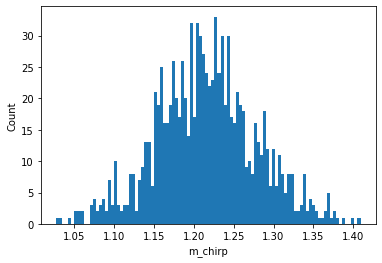

In [5]:
#histogram of m_chirp
import matplotlib.pyplot as plt
plt.hist(m_chirp,bins=100)
plt.xlabel('m_chirp')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

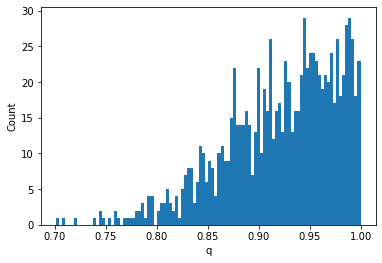

In [10]:
#histogram of q
#plt.hist(q,bins=100)
mask = q > 1
q[mask]= 1/q[mask]
plt.hist(q,bins=100)
plt.xlabel('q')
plt.ylabel('Count')

See m1 and m2 distributions

In [3]:
m_chirp = np.random.uniform(1,1.4,1000)
q = np.random.uniform(0.7,0.95,1000)
m1,m2 = m1_m2_from_m_chirp_and_q(m_chirp,q)

Text(0, 0.5, 'Count')

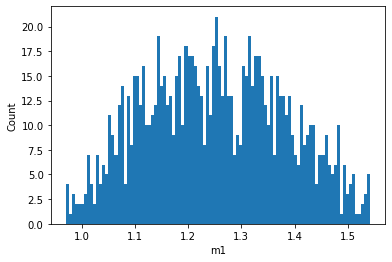

In [4]:
#histogram of m1
plt.hist(m1,bins=100)
plt.xlabel('m1')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

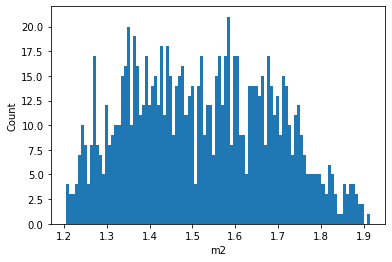

In [5]:
#histogram of m2
plt.hist(m2,bins=100)
plt.xlabel('m2')
plt.ylabel('Count')

Check lambda_tilde

4.201493709878726 9.918172839282366


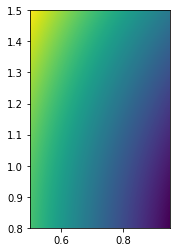

In [58]:
q=np.linspace(0.5,0.95,300)
m_chirp = np.linspace(0.8,1.5,300)
m_chirp_q = np.meshgrid(m_chirp,q)
m = m1_m2_from_m_chirp_and_q(m_chirp_q[0],m_chirp_q[1])
lambda_tilde = lambda_tilda_from_m1_m2(m[0],m[1])
#imshow lambda_tilde
plt.imshow(np.log(lambda_tilde),extent=[0.5,0.95,0.8,1.5])
print (np.min(np.log(lambda_tilde)),np.max(np.log(lambda_tilde)))



In [53]:
#2d interpolate lambda_tilde
from scipy.interpolate import interp2d
lambda_tilde_interp = interp2d(m_chirp,q,lambda_tilde)
print (lambda_tilde_interp(m_chirp,np.array([0.95,0.97])))





[[1103.12149609  355.45423717  118.23154891]
 [1103.12149609  355.45423717  118.23154891]]


Create a 2d array of mc

In [4]:
from scipy.optimize import fsolve
from GenLikeliSamples import lambda_tilde_from_m1_m2
def lambda_tilde_from_m1_m2(m1,m2):
    return (1./26)* (lambda_from_m(m1)*(1+12*m2/m1)+lambda_from_m(m2)*(1+12*m1/m2))

def lambda_tilde_from_m_chirp_q(m_chirp,q):
    return lambda_tilde_from_m1_m2(m1_m2_from_m_chirp_and_q(m_chirp,q)[0],m1_m2_from_m_chirp_and_q(m_chirp,q)[1])

mc = fsolve(lambda x: lambda_tilde_from_m_chirp_q(x,np.array([0.8,.85714])-np.array([618.5,619])),np.array([0.8,0.85714]))
print (mc)

[0.8     0.85714]


/home/Prat/Documents/Research/3Gdetec/codes/NSEOSCosmo/GenLikeliSamples.py:41: RuntimeWarning: invalid value encountered in power
  return m_chirp*(q/(1+q)**2)**(-3/5.)
/home/Prat/.local/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [18]:
log_lambda_tilde_array = np.linspace(4,10,50)
q_array = np.linspace(0.5,1,50)
q_array_log_lambda_tilde_array_mesh = np.meshgrid(q_array,log_lambda_tilde_array)
q_array_mesh_flattened = q_array_log_lambda_tilde_array_mesh[0].flatten()
log_lambda_tilde_array_mesh_flattened = q_array_log_lambda_tilde_array_mesh[1].flatten()
print(q_array_mesh_flattened,log_lambda_tilde_array_mesh_flattened)
def m_chirp_grid_from_q_log_lambda_tilde(q_array,log_lambda_tilde_array):
    mc = fsolve(lambda x: np.log(lambda_tilde_from_m_chirp_q(x, q_array_mesh_flattened))-(log_lambda_tilde_array_mesh_flattened),np.ones(len(q_array_mesh_flattened))*1.2)
    return mc.reshape(len(q_array),len(log_lambda_tilde_array))
m_chirp_grid = m_chirp_grid_from_q_log_lambda_tilde(q_array,log_lambda_tilde_array)


[0.5        0.51020408 0.52040816 ... 0.97959184 0.98979592 1.        ] [ 4.  4.  4. ... 10. 10. 10.]


In [16]:
print (np.min(m_chirp_grid),np.max(m_chirp_grid))

0.5682664935131181 2.1300111372510404


In [89]:
np.savetxt('m_chirp_grid_using_SLY.txt',m_chirp_grid)

In [19]:
from scipy.interpolate import interp2d
from copy import deepcopy
m_chirp_grid_interp = interp2d(q_array,log_lambda_tilde_array,m_chirp_grid)
q = np.array([0.97,0.7,0.8])
q_actual = deepcopy(q)
mc = np.array([1.2,1.,1.4])
lt = lambda_tilde_from_m_chirp_q(mc, q)
lt_actual = deepcopy(lt)
lt_argsort = np.argsort(lt)
q = q[lt_argsort]
lt = lt[lt_argsort]
q_argsort = np.argsort(q)

print (np.diag(m_chirp_grid_interp(q, np.log(lt))[q_argsort]))
q_actual = q_actual[lt_argsort][q_argsort]
lt_actual = lt_actual[lt_argsort][q_argsort]
print (m_chirp_grid_interp(q_actual[0], np.log(lt_actual)[0]))
print (m_chirp_grid_interp(q_actual[1], np.log(lt_actual)[1]))
print (m_chirp_grid_interp(q_actual[2], np.log(lt_actual)[2]))
print(q, lt)


mc = m_chirp_grid_interp(q[1],np.log(lt)[1])


[0.99998052 1.40002083 1.1999357 ]
[0.99998052]
[1.40002083]
[1.1999357]
[0.8  0.97 0.7 ] [ 176.72497692  350.8362899  2163.21349344]


In [43]:
intep_grid =m_chirp_grid_interp(q, np.log(lt))

In [15]:
log_lambda_tilde_array = np.linspace(4,10,50)
log_q_array = np.linspace(np.log(0.3),np.log(3),50)
#print(q_array_mesh_flattened,log_lambda_tilde_array_mesh_flattened)
def m_chirp_grid_from_log_q_log_lambda_tilde(log_q_array,log_lambda_tilde_array):
    log_q_array_log_lambda_tilde_array_mesh = np.meshgrid(log_q_array,log_lambda_tilde_array)
    log_q_array_mesh_flattened = log_q_array_log_lambda_tilde_array_mesh[0].flatten()
    log_lambda_tilde_array_mesh_flattened = log_q_array_log_lambda_tilde_array_mesh[1].flatten()
    mc = fsolve(lambda x: np.log(lambda_tilde_from_m_chirp_q(x, np.exp(log_q_array_mesh_flattened)))-(log_lambda_tilde_array_mesh_flattened),np.ones(len(log_q_array_mesh_flattened))*1.2)
    return mc.reshape(len(log_q_array),len(log_lambda_tilde_array))
m_chirp_grid1 = m_chirp_grid_from_log_q_log_lambda_tilde(log_q_array,log_lambda_tilde_array)


In [16]:
np.savetxt('m_chirp_grid_using_SLY1.txt',m_chirp_grid1)

In [48]:
x = np.linspace(0.5,0.95,50)
y = np.linspace(4,10,50)
z =np.ones((50,50))
z_interp = interp2d(x,y,z)
z_interp([0.8,0.9],[4,8])

array([[1., 1.],
       [1., 1.]])

In [49]:
x = np.arange(10)
y = np.arange(50, 60)
X, Y= np.meshgrid(x,y)

In [51]:
print(Y)

[[50 50 50 50 50 50 50 50 50 50]
 [51 51 51 51 51 51 51 51 51 51]
 [52 52 52 52 52 52 52 52 52 52]
 [53 53 53 53 53 53 53 53 53 53]
 [54 54 54 54 54 54 54 54 54 54]
 [55 55 55 55 55 55 55 55 55 55]
 [56 56 56 56 56 56 56 56 56 56]
 [57 57 57 57 57 57 57 57 57 57]
 [58 58 58 58 58 58 58 58 58 58]
 [59 59 59 59 59 59 59 59 59 59]]
